## Monte Carlo Options Pricer

This notebook will contain scratch work, thinking process, and everything that pertains to exploring data, ideas and graphs.  
I will first be diving into __Geometric Brownian Motion__ (GBM) and simulating stock prices to get a general idea of how pricing models work and what we are basing them off of (the distributions).  

Let's define GBM:  

$dS_t = \mu S_t dt + \sigma S_t dW_t$
 
where:  

$S_t$: stock price (\$)  
$\mu$: drift, expected return (%)  
$\sigma$: volatility (%)  
$dW_t$: change in Brownian motion $W_{t+dt}-W_t$  

$dW_t$ follows a normal distribution with mean 0 and variance of $dt$ such that $dW_t \sim \mathcal{N}(0, dt)$.  

It is also important to note that we will prediction __European__ options and __American__ options will call later.

#### Solution (European Options)

For **European options**, we only care about the price at the exercise date $T$. We use the explicit closed-form solution to calculate $S_T$ directly from $S_0$:  

$S_T = S_0\exp((\mu - \dfrac{\sigma ^ 2}{2})T + \sigma \sqrt{T}\,Z)$

where $Z \sim \mathcal{N}(0, 1)$.

### Path Simulation (Path-Dependent Options)

If we need to simulate the price path (e.g., for **Asian** or **American** options), we discretize the time into small increments $\Delta t$ and use the recursive formula:

$S_{t+\Delta t} = S_t\exp((\mu - \dfrac{\sigma ^ 2}{2})\Delta t + \sigma \sqrt{\Delta t}\,Z)$

where:  

$S_0$: initial stock price (\$)  
$\mu$: drift (%)  
$\sigma$: volatility  
$t$: time (years)  
$Z$: standard normal random variable

In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))


In [2]:
from src.simulator import StockPriceSimulator
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

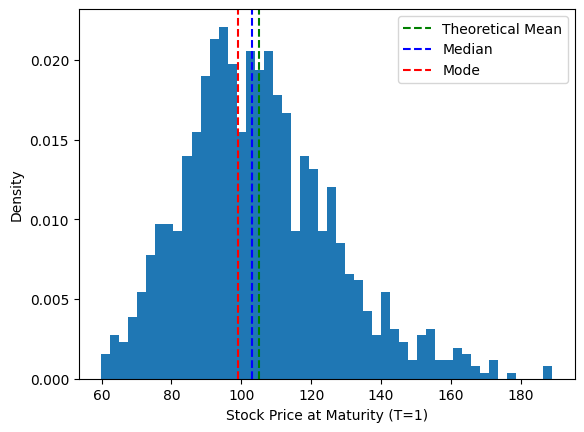

In [3]:
simulator = StockPriceSimulator(s0=100, mu=0.05, sigma=0.2, T=1, n_sims=1000, n_steps=252)
gbm_paths = simulator.simulate_gbm()

counts, bins = np.histogram(gbm_paths, bins=50, density=True)
plt.hist(gbm_paths[:, -1], bins=50, density=True)

plt.ylabel('Density')
plt.xlabel('Stock Price at Maturity (T=1)')
plt.axvline(x=simulator.s0 * np.exp(simulator.mu * simulator.T), color='g', linestyle='--', label='Theoretical Mean')
plt.axvline(x=simulator.s0 * np.exp((simulator.mu - 0.5 * simulator.sigma**2) * simulator.T), color='b', linestyle='--', label='Median')
plt.axvline(x=simulator.s0 * np.exp((simulator.mu - 1.5 * simulator.sigma**2) * simulator.T), color='r', linestyle='--', label='Mode')
plt.legend()
plt.show()

In [4]:
print(np.mean(gbm_paths[:, -1] < 100)*100,"%")

44.5 %


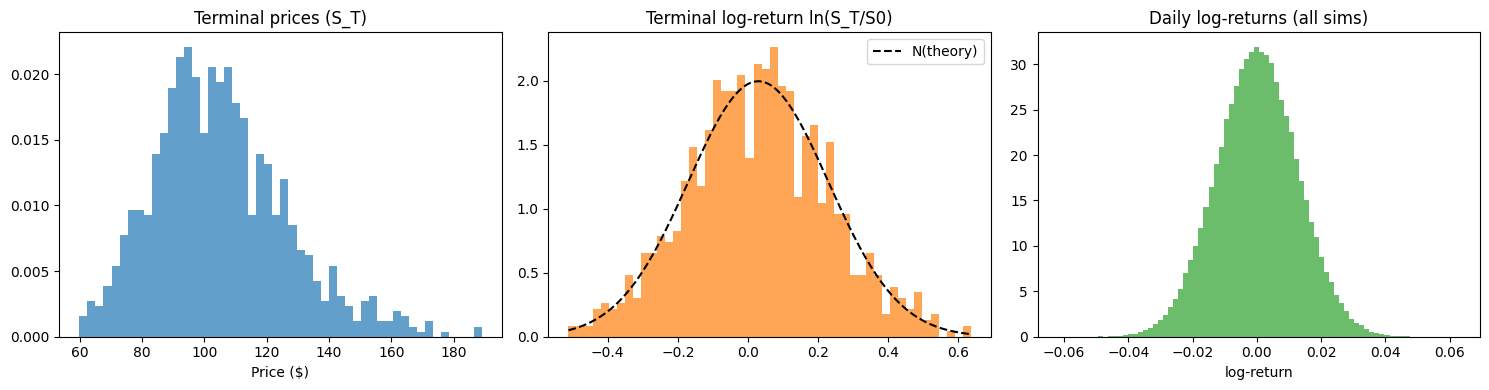

In [5]:
# plot terminal prices vs log-returns and daily log-returns

prices_T = gbm_paths[:, -1]
logret_T = np.log(prices_T / simulator.s0)                 # terminal log-return
daily_logrets = np.diff(np.log(gbm_paths), axis=1).ravel()  # all daily log-returns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Prices at maturity
axes[0].hist(prices_T, bins=50, density=True, color='C0', alpha=0.7)
axes[0].set_title('Terminal prices (S_T)')
axes[0].set_xlabel('Price ($)')

# Terminal log-returns (analytic normal overlay)
axes[1].hist(logret_T, bins=50, density=True, color='C1', alpha=0.7)
mu_T = (simulator.mu - 0.5 * simulator.sigma**2) * simulator.T
sigma_T = simulator.sigma * np.sqrt(simulator.T)
x = np.linspace(logret_T.min(), logret_T.max(), 200)
axes[1].plot(x, norm.pdf(x, loc=mu_T, scale=sigma_T), 'k--', label='N(theory)')
axes[1].set_title('Terminal log-return ln(S_T/S0)')
axes[1].legend()

# Daily log-returns (empirical)
axes[2].hist(daily_logrets, bins=80, density=True, color='C2', alpha=0.7)
axes[2].set_title('Daily log-returns (all sims)')
axes[2].set_xlabel('log-return')

plt.tight_layout()
plt.show()

We notice a log-normal distribution for the stock prices and a normal distribution for the __log-returns__, which is to be expected as we have $\ln(\dfrac{S_T}{S_0}) = (\mu - \dfrac{\sigma ^ 2}{2})T + \sigma \sqrt{T}\,Z$, which turns out to be a normal distribution with a mean of $(\mu - \dfrac{\sigma ^ 2}{2})T$ and a standard deviation of $\sigma \sqrt{T}$.

### Visualization

Let's take a look at what the GBM simulation looks like.

In [6]:
#simulator.plot_paths(gbm_paths)

#### Simulating ABM

What we like about GBM is that values can only stay positive, which reflects the behaviour of stocks (they can't go negative).  
ABM models linear change and GBM models log-normal change. Since we have $\dfrac{dS}{S_t}$ in GBM, integrating gives $\ln(S_t)$, then we exponentiate. So $S_t = S_0 \exp({\dots}) > 0$  

For ABM we have $dS_t=\mu{}dt+\sigma{}dW_t$ where $dW_t \sim \mathcal{N}(0,dt)$. As time goes on, the "spread" of possible values increases. Variance grows over time. Standard deviation is $\sqrt{t}$ (for $W_t$). We solve and find $S_t = S_0 + \mu{}t+\sigma{}W_t$ and $W_t \sim \mathcal{N}(0,t)$.  
We expand $W_t = \sqrt{t}Z$ such that $Z \sim \mathcal{N}(0,1)$, i.e. we're scaling $Z$ by $\sqrt{t}$ and variance is then $t$.  

We now have $dS_t = \mu{}dt+\sigma{}\sqrt{dt}Z$ where $\mu$ and $\sigma$ are constants in \$/year and \$/$\sqrt{year}$ of drift and volatility respectively.

Mean: $\mathbb{E}[S_t] = \mathbb{E}[\mu{}t+\sigma{}W_t] = \mu{}\mathbb{E}[t] + \mathbb{E}[\sigma]\mathbb{E}[W_t] = \mu{}t + \mathbb{E}[\sigma](0) = \mu{}t\;\;(+ S_0)$  
Recall $W_t \sim \mathcal{N}(0,t)$ therefore its mean is 0, so $\mathbb{E}[W_t] = 0$.  
Variance: $\sigma{}^2t$

In [7]:
abm_paths = simulator.simulate_normal()

In [8]:
#simulator.plot_paths(abm_paths)

#### Probability of going negative

S0 = 100  
mu = 0.10 (10% annual drift)  
sigma = 0.20 (20% annual vol)  
T = 1.0  
n_steps = 252  

$S_{T=1} < 0$  
$S_{T=1} = 100 + sum\;of\;increments \sim \mathcal{N}(10,20^2)$ (we have 10 and 20 because for ABM, we need dollar amounts so $0.1 * S_0 = \$10$ and $0.2 * S_0 = \$20$)  
$S_{T=1} \sim \mathcal{N}(110,20^2)$  
$S_{T=1} = 110 + 20Z$ where $ Z \sim \mathcal{N}(0,1)$

$110 + 20Z < 0 \to Z < -5.5 \to P(Z < -5.5)$ gives us the chance of going below 0$.  
We easily compute this with the CDF of the normal distribution.

In [9]:
prob = norm.cdf(-5.5)
s = float(prob)
print(f"{s*100:.7f}%")

0.0000019%


So to see our stock go 'negative' we need different values for drift and volatility, so let's try some.

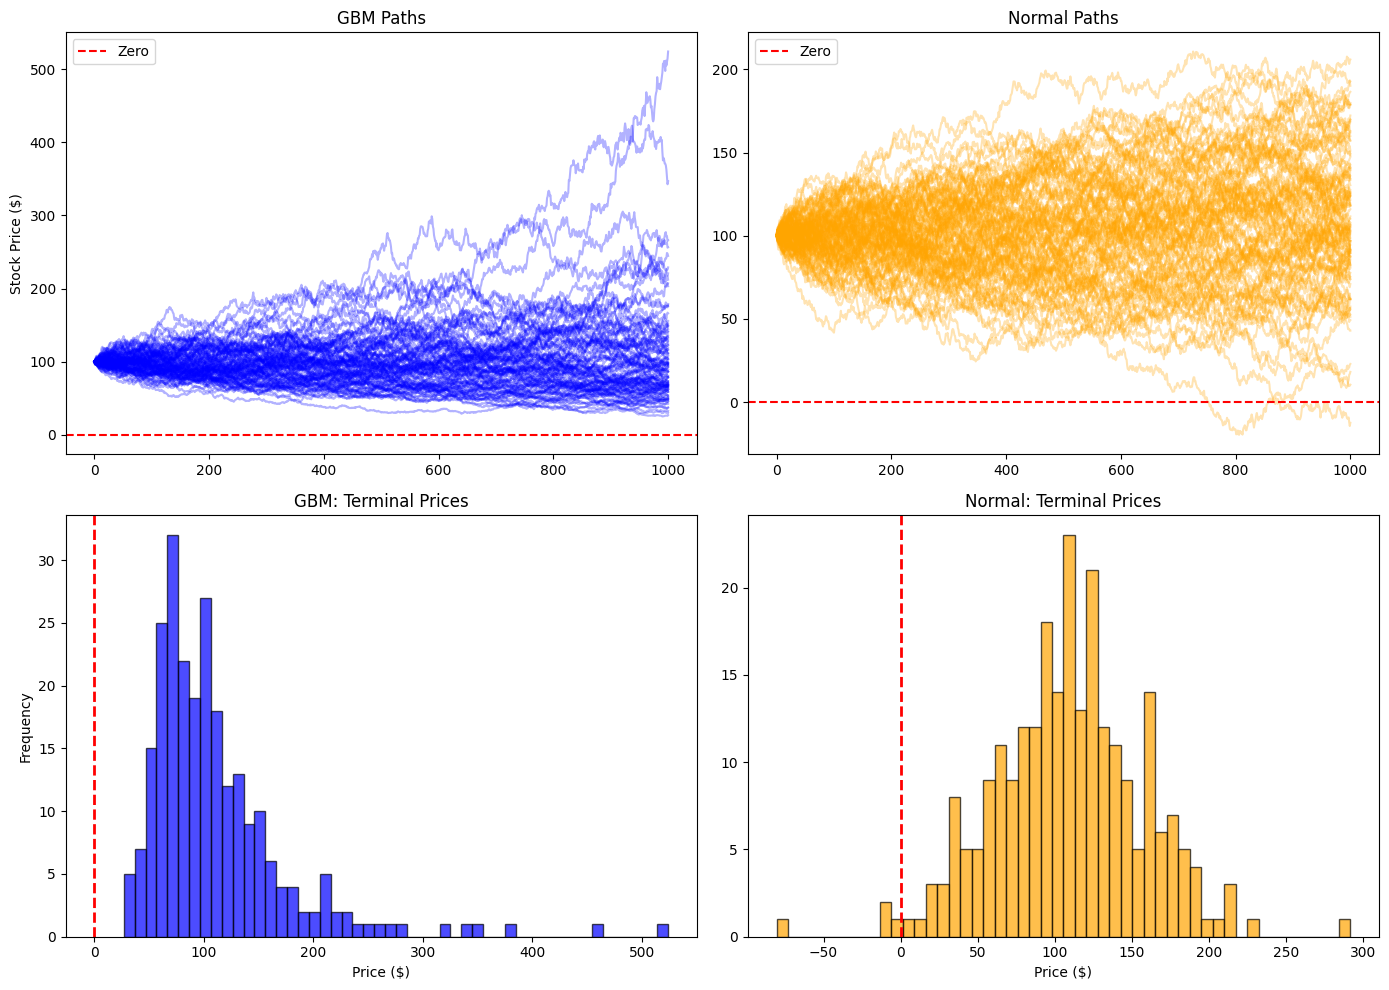

MODEL COMPARISON ANALYSIS

GBM MODEL:
  Min price: $23.60
  Max price: $524.13
  Mean terminal price: $111.08
  % of paths with negative prices: 0.00%

NORMAL MODEL:
  Min price: $-86.17
  Max price: $293.75
  Mean terminal price: $108.92
  % of paths with negative prices: 2.78%

THE PROBLEM:
  - Normal model produces NEGATIVE STOCK PRICES!
  - This is impossible in reality (limited liability)
  - Option prices would be WRONG

WHY GBM IS CORRECT:
  - Models RETURNS as normal, not prices
  - Prices are log-normal (always positive)
  - Volatility scales with price level
  - This is the Black-Scholes assumption


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
S0 = 100
mu = 0.10  # 10% annual drift
sigma = 0.50  # 20% annual vol
T = 1.0
n_steps = 252
n_sims = 1000

simulator_highvol = StockPriceSimulator(S0, mu, sigma, T, n_steps, n_sims)

# Generate paths
gbm_paths = simulator_highvol.simulate_gbm()
normal_paths = simulator_highvol.simulate_normal()

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ===== TOP LEFT: Sample Paths =====
axes[0, 0].plot(gbm_paths[:100].T, alpha=0.3, color='blue')
axes[0, 0].set_title('GBM Paths')
axes[0, 0].set_ylabel('Stock Price ($)')
axes[0, 0].axhline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].legend()

axes[0, 1].plot(normal_paths[:100].T, alpha=0.3, color='orange')
axes[0, 1].set_title('Normal Paths')
axes[0, 1].axhline(0, color='red', linestyle='--', label='Zero')
axes[0, 1].legend()

# ===== BOTTOM LEFT: Terminal Price Distribution =====
axes[1, 0].hist(gbm_paths[:, -1], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_title('GBM: Terminal Prices')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(normal_paths[:, -1], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('Normal: Terminal Prices')
axes[1, 1].set_xlabel('Price ($)')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

# ===== CRITICAL ANALYSIS =====
print("=" * 60)
print("MODEL COMPARISON ANALYSIS")
print("=" * 60)

print("\nGBM MODEL:")
print(f"  Min price: ${gbm_paths.min():.2f}")
print(f"  Max price: ${gbm_paths.max():.2f}")
print(f"  Mean terminal price: ${gbm_paths[:, -1].mean():.2f}")
print(f"  % of paths with negative prices: {(gbm_paths < 0).any(axis=1).mean() * 100:.2f}%")

print("\nNORMAL MODEL:")
print(f"  Min price: ${normal_paths.min():.2f}")  # <-- WILL BE NEGATIVE!
print(f"  Max price: ${normal_paths.max():.2f}")
print(f"  Mean terminal price: ${normal_paths[:, -1].mean():.2f}")
print(f"  % of paths with negative prices: {(normal_paths < 0).any(axis=1).mean() * 100:.2f}%")

print("\nTHE PROBLEM:")
if (normal_paths < 0).any():
    print("  - Normal model produces NEGATIVE STOCK PRICES!")
    print("  - This is impossible in reality (limited liability)")
    print("  - Option prices would be WRONG")
    
print("\nWHY GBM IS CORRECT:")
print("  - Models RETURNS as normal, not prices")
print("  - Prices are log-normal (always positive)")
print("  - Volatility scales with price level")
print("  - This is the Black-Scholes assumption")

One more distribution
====================================  

#### Student t-Distribution

The Student's t-distribution is preferred over the Normal distribution for modeling asset returns because it features "fat tails" (leptokurtosis). This allows it to more accurately capture extreme market events (outliers) that occur more frequently in real-world data than a Normal distribution predicts.
Because real markets experience crashes more often, resulting in fatter tails in the log returns distribution.



Let's see what it looks like.

-3.3851848668182165


Text(0, 0.5, 'PDF')

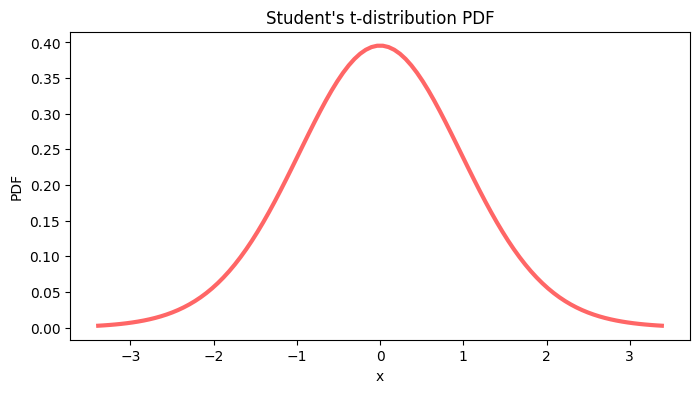

In [11]:
from scipy.stats import t

df = 30

x = np.linspace(t.ppf(0.001, df), t.ppf(0.999, df), 100)

print(t.ppf(0.001, df))
y = t.pdf(x, df)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'r-', lw=3, alpha=0.6, label=f't-distribution (df={df})')
plt.title("Student's t-distribution PDF")
plt.xlabel("x")
plt.ylabel("PDF")

Let's plot some AAPL stock as well.

In [12]:
import yfinance as yf
import pandas as pd

df: pd.DataFrame = yf.download('AAPL', start='2020-01-01', end='2021-01-01')

[*********************100%***********************]  1 of 1 completed


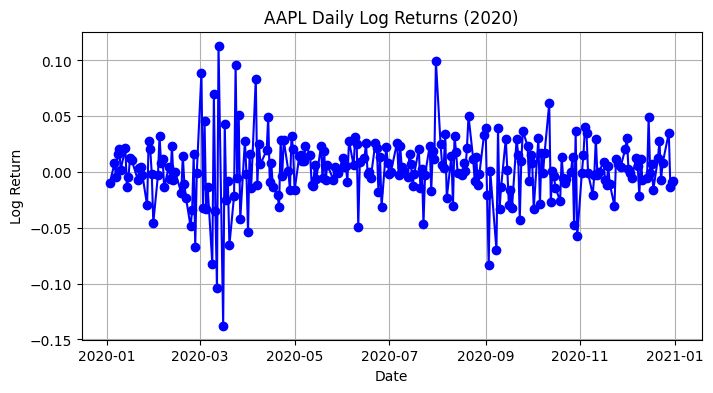

In [13]:
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))

plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Log Return'], marker='o', linestyle='-', color='blue')
plt.title('AAPL Daily Log Returns (2020)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid()
plt.show()

In [14]:
df.head()

Price,Close,High,Low,Open,Volume,Log Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2020-01-02,72.400513,72.460776,71.156674,71.409778,135480400,NaN
2020-01-03,71.696640,72.455958,71.472462,71.629145,146322800,-0.009769
2020-01-06,72.267944,72.306514,70.568518,70.819216,118387200,0.007937
2020-01-07,71.928032,72.533072,71.708672,72.277555,108872000,-0.004715
2020-01-08,73.085106,73.386423,71.631552,71.631552,132079200,0.015959


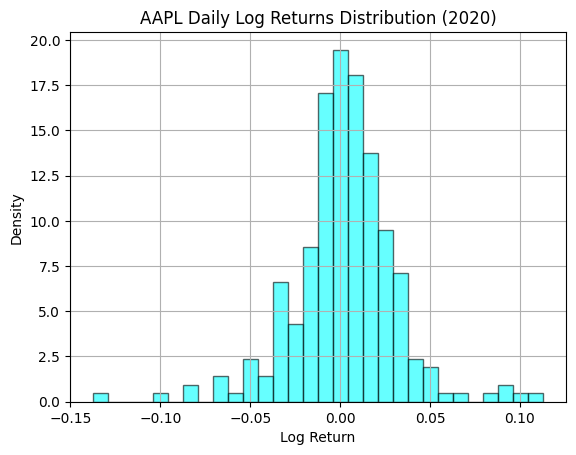

In [15]:
plt.hist(df['Log Return'].dropna(), bins=30, density=True, alpha=0.6, color='cyan', edgecolor='black')
plt.title('AAPL Daily Log Returns Distribution (2020)')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid()
plt.show()

In [16]:
print(df['Log Return'].kurtosis()) # excess kurtosis = kurtosis - 3
print(df['Log Return'].skew()) # skewness, where outliers cause a long tail on one side

3.9192573641203596
-0.3033518569731767


Notice the high kurtosis value which is $> 3$ and suggests a the distribution is __leptokurtic__, i.e. it has "fat" tails.  
The negative skew means distribution has a long left tail. Plotting AAPL log returns goes to show that log returns don't seem to follow a normal distribution and it seems to rather follow a skewed normal distribution with a thicker tail, much more similar to a Student t-distribution.

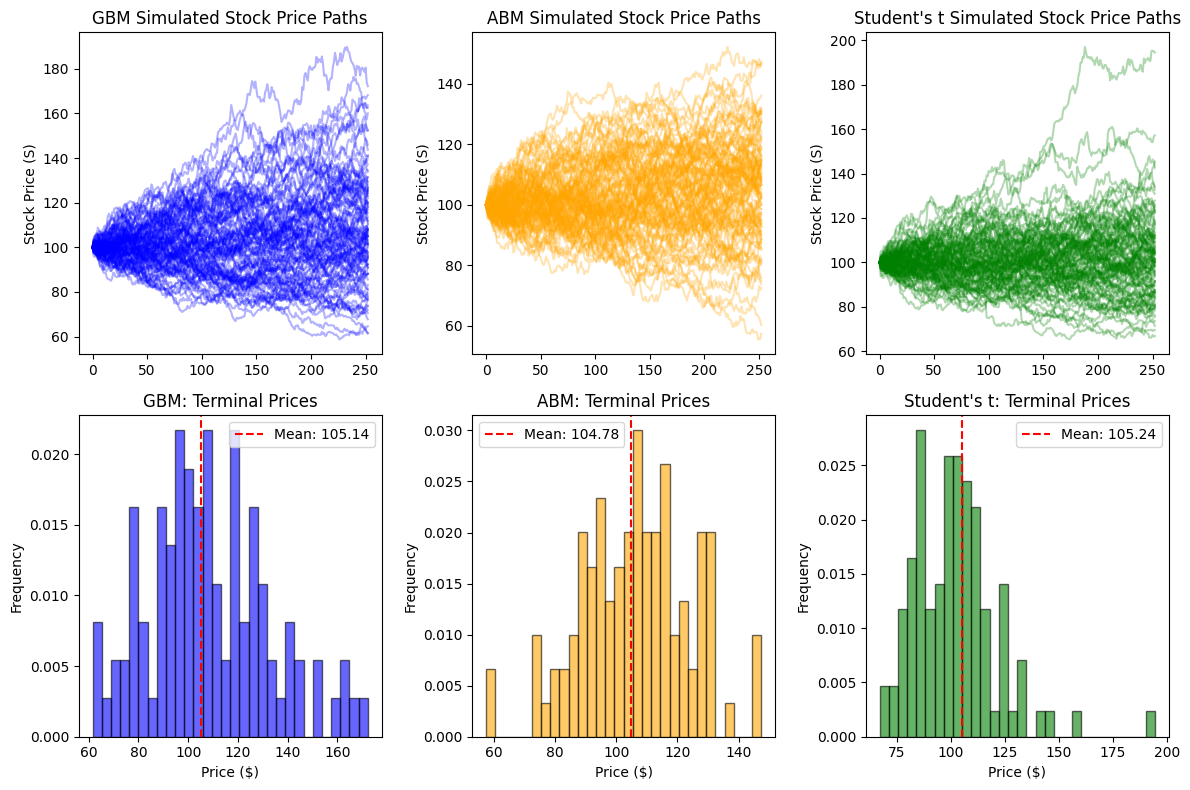

In [17]:
np.random.seed(42)
simulator = StockPriceSimulator(s0=100, mu=0.05, sigma=0.2, T=1, n_sims=1000, n_steps=252)
gbm_paths = simulator.simulate_gbm()
normal_paths = simulator.simulate_normal()
student_t_paths = simulator.simulate_student_t()

simulator.plot_paths_and_terminal_hist(show_paths=100, gbm_paths=gbm_paths, abm_paths=normal_paths, student_t_paths=student_t_paths)

All three models have around the same mean and I like to think this is due to the relatively small parameters for volatility and std dev.

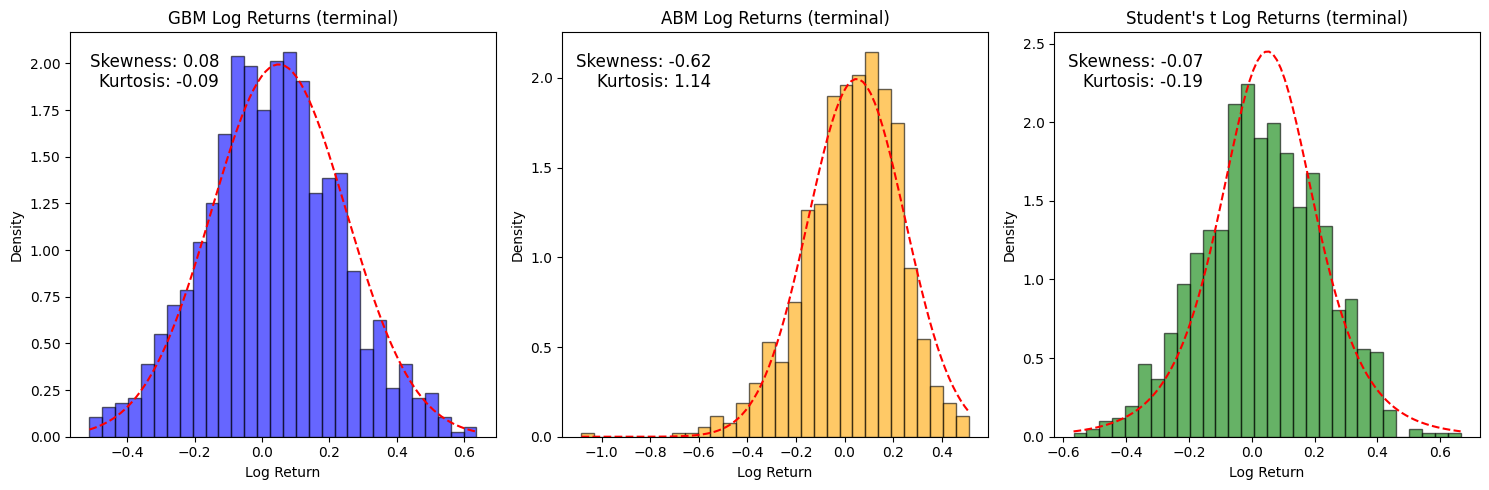

In [18]:
simulator.plot_log_returns(gbm_paths=gbm_paths, abm_paths=normal_paths, student_t_paths=student_t_paths)

Interestingly enough, we notice AAPL log returns (1 year) looks more similar to the simulated ABM log returns.